In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from tqdm import tqdm
import warnings


config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

warnings.filterwarnings("ignore")

C:\Users\siraj\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\siraj\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\siraj\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\siraj\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [3]:
# Labels for training
labels = [
    'one', 'two', 'zero', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'
]

In [14]:
train_audio_path = 'Dataset/augmented_dataset'
all_wave = []
all_label = []
for label in tqdm(labels):
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


 10%|████████▎                                                                          | 1/10 [00:39<05:55, 39.47s/it]


 20%|████████████████▌                                                                  | 2/10 [01:07<04:48, 36.10s/it]


 30%|████████████████████████▉                                                          | 3/10 [01:47<04:20, 37.15s/it]


 40%|█████████████████████████████████▏                                                 | 4/10 [02:23<03:41, 36.86s/it]


 50%|█████████████████████████████████████████▌                                         | 5/10 [03:36<03:59, 47.86s/it]


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [04:10<02:54, 43.64s/it]


 70%|██████████████████████████████████████████████████████████                         | 7/10 [04:55<02:12, 44.05s/it]


 80%|████████████████

In [15]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

label_enconder = LabelEncoder()
y = label_enconder.fit_transform(all_label)
classes = list(label_enconder.classes_)
y = np_utils.to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.


In [16]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.3,random_state=777,shuffle=True)

In [18]:
#Main model
from keras.layers import Bidirectional, BatchNormalization, CuDNNGRU, TimeDistributed

In [19]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(inputs)

#First Conv1D layer
x = Conv1D(8,13, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Second Conv1D layer
x = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Third Conv1D layer
x = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

x = Bidirectional(CuDNNGRU(128, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(CuDNNGRU(128, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(CuDNNGRU(128, return_sequences=False), merge_mode='sum')(x)

x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

#Dense Layer 1
x = Dense(256, activation='relu')(x)
outputs = Dense(len(labels), activation="softmax")(x)

model = Model(inputs, outputs)
model.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8000, 1)           4         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0  

In [20]:
model.compile(loss='categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])

In [21]:
checkpoint = ModelCheckpoint('deepSpeech_model.hdf5', monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')

In [22]:
hist = model.fit(
    x=x_train, 
    y=y_train,
    epochs=20, 
    callbacks=[checkpoint], 
    batch_size=32, 
    validation_data=(x_valid,y_valid)
)


Train on 9321 samples, validate on 3996 samples
Epoch 1/20
9321/9321 [==============================] - 123s 13ms/step - loss: 0.8984 - accuracy: 0.6945 - val_loss: 2.8067 - val_accuracy: 0.1599
Epoch 2/20
9321/9321 [==============================] - 120s 13ms/step - loss: 0.2655 - accuracy: 0.9113 - val_loss: 0.8756 - val_accuracy: 0.7603
Epoch 3/20
9321/9321 [==============================] - 120s 13ms/step - loss: 0.2030 - accuracy: 0.9318 - val_loss: 0.1943 - val_accuracy: 0.9515
Epoch 4/20
9321/9321 [==============================] - 120s 13ms/step - loss: 0.1713 - accuracy: 0.9434 - val_loss: 0.1063 - val_accuracy: 0.9650
Epoch 5/20
9321/9321 [==============================] - 120s 13ms/step - loss: 0.1379 - accuracy: 0.9538 - val_loss: 0.5190 - val_accuracy: 0.8413
Epoch 6/20
9321/9321 [==============================] - 124s 13ms/step - loss: 0.1266 - accuracy: 0.9575 - val_loss: 0.1373 - val_accuracy: 0.9547
Epoch 7/20
9321/9321 [==============================] - 129s 14ms/ste

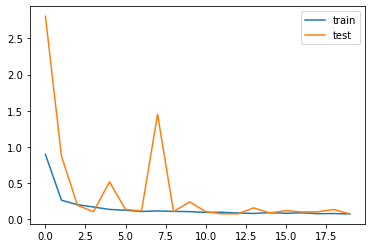

In [23]:
from matplotlib import pyplot
pyplot.plot(hist.history['loss'], label='train')
pyplot.plot(hist.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

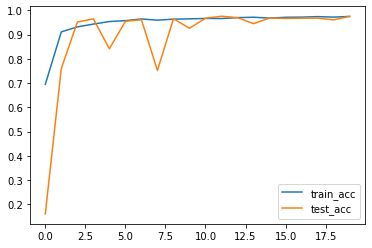

In [33]:
pyplot.plot(hist.history['accuracy'], label='train_acc')
pyplot.plot(hist.history['val_accuracy'], label='test_acc')
pyplot.legend()
pyplot.show()

In [24]:
model.save('deepSpeech.hdf5')

In [25]:
from keras.models import load_model
model = load_model('deepSpeech.hdf5')

In [26]:
def s2t_predict(audio, shape_num=8000):
    prob=model.predict(audio.reshape(1,shape_num,1))
    index=np.argmax(prob[0])
    return classes[index]

In [27]:
import random
index=random.randint(0,len(x_valid)-1)
samples=x_valid[index].ravel()
print("Audio:",classes[np.argmax(y_valid[index])])
ipd.Audio(samples, rate=8000)

Audio: nine


In [28]:
samples.shape

(8000,)

In [29]:
print("Text:",s2t_predict(samples))

Text: nine


In [30]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'one.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [31]:
#reading the voice commands
test, test_rate = librosa.load('one.wav', sr = 16000)
test_sample = librosa.resample(test, test_rate, 8000)
print(test_sample.shape)
ipd.Audio(test_sample,rate=8000)

(8000,)


In [32]:
#converting voice commands to text
s2t_predict(test_sample)

'one'